## Before you start

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [ ]:
!nvidia-smi

Sat Nov 15 08:44:37 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   46C    P8             12W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

**NOTE:** To make it easier for us to manage datasets, images and models we create a `HOME` constant.

In [ ]:
import os
HOME = os.getcwd()
print("HOME:", HOME)

HOME: /content


## Install Segment Anything Model (SAM) and other dependencies

In [ ]:
!pip install -q 'git+https://github.com/facebookresearch/segment-anything.git'

  Preparing metadata (setup.py) ... done


In [ ]:
!pip install -q jupyter_bbox_widget roboflow dataclasses-json supervision==0.23.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.5/151.5 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 21.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 29.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 18.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 22.4 MB/s eta 0:00:00


### Download SAM weights

In [ ]:
!mkdir -p {HOME}/weights
!wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth -P {HOME}/weights

In [ ]:
import os

CHECKPOINT_PATH = os.path.join(HOME, "weights", "sam_vit_h_4b8939.pth")
print(CHECKPOINT_PATH, "; exist:", os.path.isfile(CHECKPOINT_PATH))

/content/weights/sam_vit_h_4b8939.pth ; exist: True


## Download Example Data

**NONE:** Let's download few example images. Feel free to use your images or videos.

In [ ]:
# MODIFIED CELL - Data Directory Setup
!mkdir -p {HOME}/data
!mkdir -p {HOME}/outputs

# Optional: Keep dog images for comparison/testing
# !wget -q https://media.roboflow.com/notebooks/examples/dog.jpeg -P {HOME}/data

print("✓ Data and outputs directories created")
print(f"Please upload F1 images to: {HOME}/data/")

✓ Data and outputs directories created
Please upload F1 images to: /content/data/


In [ ]:
# To Upload F1 Car Images
from google.colab import files
import shutil

print("Please upload your F1 car images:")
print("1. Upload the 2016 Haas F1 car image (name it: f1_2016_baseline.jpg)")
print("2. Upload the 2025 Haas F1 car image (name it: f1_2025_current.jpg)")

uploaded = files.upload()

# Move uploaded files to data directory
for filename in uploaded.keys():
    shutil.move(filename, os.path.join(HOME, "data", filename))
    print(f"✓ Uploaded: {filename}")

Please upload your F1 car images:
1. Upload the 2016 Haas F1 car image (name it: f1_2016_baseline.jpg)
2. Upload the 2025 Haas F1 car image (name it: f1_2025_current.jpg)


Saving f1_2016_baseline.jpg to f1_2016_baseline.jpg
Saving f1_2025_current.jpg to f1_2025_current.jpg
✓ Uploaded: f1_2016_baseline.jpg
✓ Uploaded: f1_2025_current.jpg


## Load Model

In [ ]:
import torch

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
MODEL_TYPE = "vit_h"

In [ ]:
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH).to(device=DEVICE)

---
## 🏎️ F1 Visual Change Detection Pipeline - Step 2: SAM Segmentation

**Pipeline Context:**
- **Input**: Two F1 car images (2016 baseline vs 2025 current)
- **Task**: Segment the car body from background
- **Output**: Segmentation masks for both images
- **Next Step**: Image alignment (SIFT + RANSAC)

---

## Automated Mask Generation

To run automatic mask generation, provide a SAM model to the `SamAutomaticMaskGenerator` class. Set the path below to the SAM checkpoint. Running on CUDA and with the default model is recommended.

In [ ]:
mask_generator = SamAutomaticMaskGenerator(sam)

In [ ]:
# F1 Pipeline Configuration
BASELINE_IMAGE = "f1_2016_baseline.jpg"  # Your 2016 Haas image
CURRENT_IMAGE = "f1_2025_current.jpg"    # Your 2025 Haas image

BASELINE_PATH = os.path.join(HOME, "data", BASELINE_IMAGE)
CURRENT_PATH = os.path.join(HOME, "data", CURRENT_IMAGE)

# Verify images exist
print("Baseline image exists:", os.path.isfile(BASELINE_PATH))
print("Current image exists:", os.path.isfile(CURRENT_PATH))

Baseline image exists: True
Current image exists: True


### Generate masks with SAM

In [ ]:
# Generate masks for BASELINE image (2016)
import cv2
import supervision as sv

baseline_bgr = cv2.imread(BASELINE_PATH)
baseline_rgb = cv2.cvtColor(baseline_bgr, cv2.COLOR_BGR2RGB)

print("Generating masks for 2016 baseline car...")
baseline_sam_result = mask_generator.generate(baseline_rgb)
print(f"✓ Generated {len(baseline_sam_result)} masks for baseline")

# Generate masks for CURRENT image (2025)
current_bgr = cv2.imread(CURRENT_PATH)
current_rgb = cv2.cvtColor(current_bgr, cv2.COLOR_BGR2RGB)

print("Generating masks for 2025 current car...")
current_sam_result = mask_generator.generate(current_rgb)
print(f"✓ Generated {len(current_sam_result)} masks for current")

Generating masks for 2016 baseline car...
✓ Generated 55 masks for baseline
Generating masks for 2025 current car...
✓ Generated 48 masks for current


### Output format

`SamAutomaticMaskGenerator` returns a `list` of masks, where each mask is a `dict` containing various information about the mask:

* `segmentation` - `[np.ndarray]` - the mask with `(W, H)` shape, and `bool` type
* `area` - `[int]` - the area of the mask in pixels
* `bbox` - `[List[int]]` - the boundary box of the mask in `xywh` format
* `predicted_iou` - `[float]` - the model's own prediction for the quality of the mask
* `point_coords` - `[List[List[float]]]` - the sampled input point that generated this mask
* `stability_score` - `[float]` - an additional measure of mask quality
* `crop_box` - `List[int]` - the crop of the image used to generate this mask in `xywh` format

In [ ]:
#print(sam_result[0].keys())

### Results visualisation with Supervision

As of version `0.5.0` Supervision has native support for SAM.

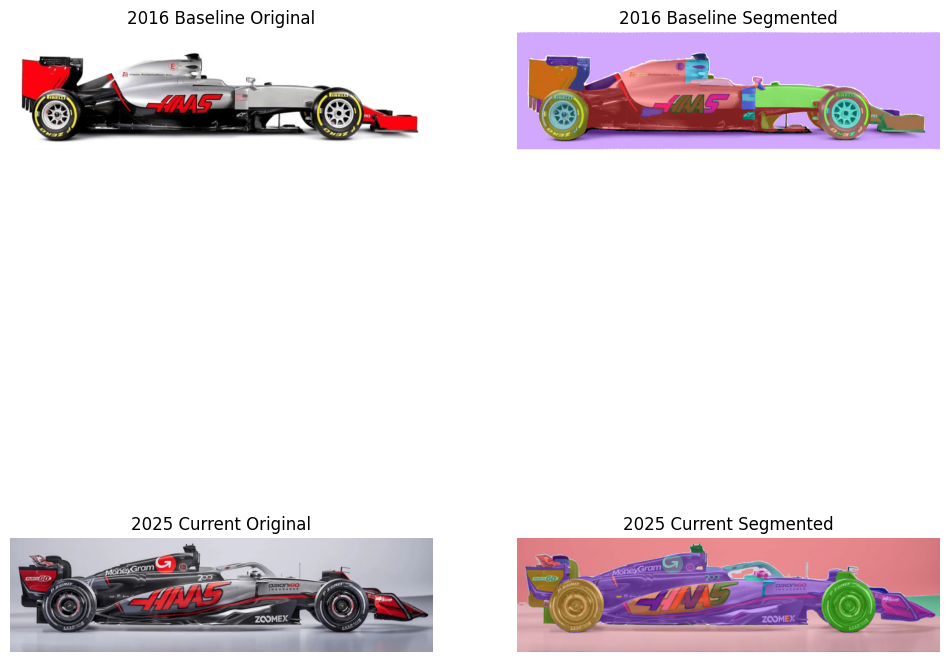

In [ ]:
# Visualize BOTH images side-by-side
mask_annotator = sv.MaskAnnotator(color_lookup=sv.ColorLookup.INDEX)

# Annotate baseline
baseline_detections = sv.Detections.from_sam(sam_result=baseline_sam_result)
baseline_annotated = mask_annotator.annotate(scene=baseline_bgr.copy(), detections=baseline_detections)

# Annotate current
current_detections = sv.Detections.from_sam(sam_result=current_sam_result)
current_annotated = mask_annotator.annotate(scene=current_bgr.copy(), detections=current_detections)

# Plot all 4 images
sv.plot_images_grid(
    images=[baseline_bgr, baseline_annotated, current_bgr, current_annotated],
    grid_size=(2, 2),
    titles=['2016 Baseline Original', '2016 Baseline Segmented',
            '2025 Current Original', '2025 Current Segmented']
)

### Interaction with segmentation results

In [ ]:
#masks = [
 #   mask['segmentation']
  #  for mask
   # in sorted(sam_result, key=lambda x: x['area'], reverse=True)
#]

#sv.plot_images_grid(
 #   images=masks,
  #  grid_size=(8, int(len(masks) / 8)),
   # size=(16, 16)
#)

## Generate Segmentation with Bounding Box

The `SamPredictor` class provides an easy interface to the model for prompting the model. It allows the user to first set an image using the `set_image` method, which calculates the necessary image embeddings. Then, prompts can be provided via the `predict` method to efficiently predict masks from those prompts. The model can take as input both point and box prompts, as well as masks from the previous iteration of prediction.

In [ ]:
mask_predictor = SamPredictor(sam)

In [ ]:
IMAGE_NAME = BASELINE_IMAGE
IMAGE_PATH = BASELINE_PATH

print(f"Using: {IMAGE_NAME}")

Using: f1_2016_baseline.jpg


### Draw Box



In [ ]:
# helper function that loads an image before adding it to the widget

import base64

def encode_image(filepath):
    with open(filepath, 'rb') as f:
        image_bytes = f.read()
    encoded = str(base64.b64encode(image_bytes), 'utf-8')
    return "data:image/jpg;base64,"+encoded

**NOTE:** Execute cell below and use your mouse to draw bounding box on the image 👇

In [ ]:
IS_COLAB = True

if IS_COLAB:
    from google.colab import output
    output.enable_custom_widget_manager()

from jupyter_bbox_widget import BBoxWidget

widget = BBoxWidget()
widget.image = encode_image(IMAGE_PATH)
widget

BBoxWidget(colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#b…

In [ ]:
widget.bboxes

[{'x': 11, 'y': 40, 'width': 187, 'height': 112, 'label': ''}]

### Generate masks with SAM

**NOTE:** `SamPredictor.predict` method takes `np.ndarray` `box` argument in `[x_min, y_min, x_max, y_max]` format. Let's reorganise your data first

In [ ]:
import cv2
import numpy as np
import supervision as sv

# Get the bounding box (either from widget or default)
default_box = {'x': 50, 'y': 100, 'width': 900, 'height': 400, 'label': 'F1 Car'}

box = widget.bboxes[0] if widget.bboxes else default_box
box_coords = np.array([
    box['x'],
    box['y'],
    box['x'] + box['width'],
    box['y'] + box['height']
])

print("Bounding box coordinates:", box_coords)

# ----- Process BASELINE image -----
baseline_bgr = cv2.imread(BASELINE_PATH)
baseline_rgb = cv2.cvtColor(baseline_bgr, cv2.COLOR_BGR2RGB)

mask_predictor.set_image(baseline_rgb)
baseline_masks, baseline_scores, baseline_logits = mask_predictor.predict(
    box=box_coords,
    multimask_output=True
)
print(f"✓ Baseline: Generated {len(baseline_masks)} masks")

# ----- Process CURRENT image -----
current_bgr = cv2.imread(CURRENT_PATH)
current_rgb = cv2.cvtColor(current_bgr, cv2.COLOR_BGR2RGB)

mask_predictor.set_image(current_rgb)
current_masks, current_scores, current_logits = mask_predictor.predict(
    box=box_coords,  # Use same box for consistency
    multimask_output=True
)
print(f"✓ Current: Generated {len(current_masks)} masks")

Bounding box coordinates: [ 11  40 198 152]
✓ Baseline: Generated 3 masks
✓ Current: Generated 3 masks


### Results visualisation with Supervision

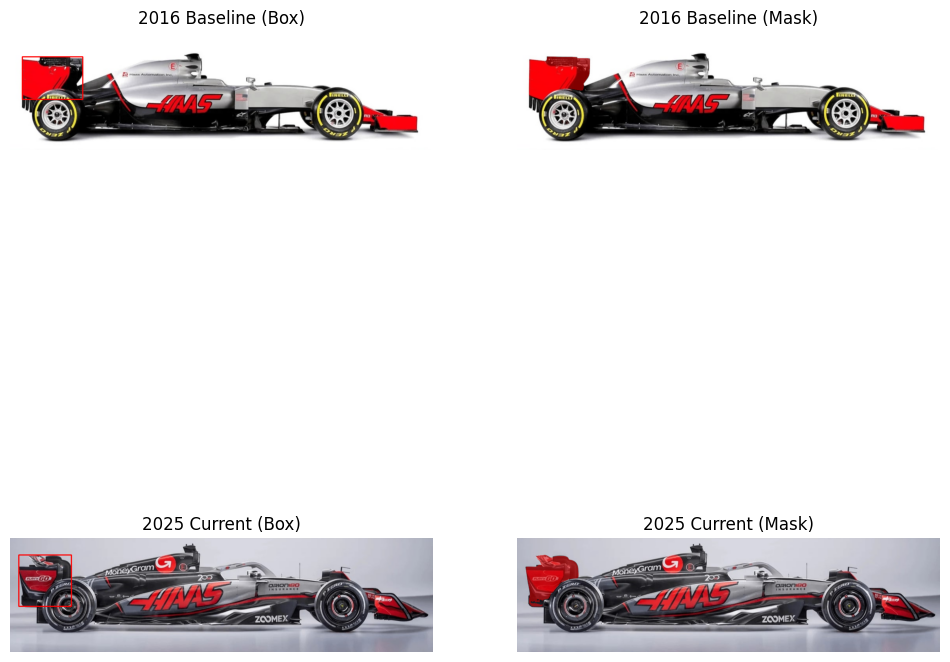

In [ ]:
box_annotator = sv.BoxAnnotator(color=sv.Color.RED, color_lookup=sv.ColorLookup.INDEX)
mask_annotator = sv.MaskAnnotator(color=sv.Color.RED, color_lookup=sv.ColorLookup.INDEX)

# Process BASELINE
baseline_detections = sv.Detections(
    xyxy=sv.mask_to_xyxy(masks=baseline_masks),
    mask=baseline_masks
)
baseline_detections = baseline_detections[baseline_detections.area == np.max(baseline_detections.area)]

baseline_boxed = box_annotator.annotate(scene=baseline_bgr.copy(), detections=baseline_detections)
baseline_segmented = mask_annotator.annotate(scene=baseline_bgr.copy(), detections=baseline_detections)

# Process CURRENT
current_detections = sv.Detections(
    xyxy=sv.mask_to_xyxy(masks=current_masks),
    mask=current_masks
)
current_detections = current_detections[current_detections.area == np.max(current_detections.area)]

current_boxed = box_annotator.annotate(scene=current_bgr.copy(), detections=current_detections)
current_segmented = mask_annotator.annotate(scene=current_bgr.copy(), detections=current_detections)

# Plot comparison
sv.plot_images_grid(
    images=[baseline_boxed, baseline_segmented, current_boxed, current_segmented],
    grid_size=(2, 2),
    titles=['2016 Baseline (Box)', '2016 Baseline (Mask)',
            '2025 Current (Box)', '2025 Current (Mask)']
)

### Interaction with segmentation results

In [ ]:
# Install LoFTR and dependencies
print("Installing LoFTR dependencies...")
!pip install -q torch einops yacs kornia
!git clone https://github.com/zju3dv/LoFTR --depth 1
!mv LoFTR/* . && rm -rf LoFTR

print("✓ LoFTR code downloaded")

Installing LoFTR dependencies...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 61.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 97.7 MB/s eta 0:00:00
Cloning into 'LoFTR'...
remote: Enumerating objects: 173, done.
remote: Counting objects: 100% (173/173), done.
remote: Compressing objects: 100% (142/142), done.
remote: Total 173 (delta 26), reused 99 (delta 21), pack-reused 0 (from 0)
Receiving objects: 100% (173/173), 26.27 MiB | 12.78 MiB/s, done.
Resolving deltas: 100% (26/26), done.
mv: cannot move 'LoFTR/data' to './data': Directory not empty
✓ LoFTR code downloaded


In [ ]:
# Download pretrained LoFTR weights
import os

!mkdir -p {HOME}/weights
%cd {HOME}/weights/

# Download outdoor model (best for studio/track images)
!gdown --id 1M-VD35-qdB5Iw-AtbDBCKC7hPolFW9UY  # outdoor-ds model

%cd {HOME}

LOFTR_WEIGHT_PATH = os.path.join(HOME, "weights", "outdoor_ds.ckpt")
print(f"✓ LoFTR weights downloaded: {LOFTR_WEIGHT_PATH}")
print(f"  Exists: {os.path.isfile(LOFTR_WEIGHT_PATH)}")

/content/weights
/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1M-VD35-qdB5Iw-AtbDBCKC7hPolFW9UY
From (redirected): https://drive.google.com/uc?id=1M-VD35-qdB5Iw-AtbDBCKC7hPolFW9UY&confirm=t&uuid=a2a51d7e-eb5b-4da9-a8f4-1aaea836144e
To: /content/weights/outdoor_ds.ckpt
100% 46.3M/46.3M [00:00<00:00, 65.1MB/s]
/content
✓ LoFTR weights downloaded: /content/weights/outdoor_ds.ckpt
  Exists: True


In [ ]:
# Load LoFTR matcher
import torch
import sys
sys.path.insert(0, HOME)  # Add LoFTR code to path

from src.loftr import LoFTR, default_cfg

# Initialize LoFTR with outdoor config (best for F1 cars)
matcher = LoFTR(config=default_cfg)
matcher.load_state_dict(torch.load(LOFTR_WEIGHT_PATH)['state_dict'])
matcher = matcher.eval().cuda()

print("✓ LoFTR model loaded and ready on GPU")
print("  Model type: Outdoor (optimized for studio/track images)")

✓ LoFTR model loaded and ready on GPU
  Model type: Outdoor (optimized for studio/track images)


In [ ]:
# Prepare images for LoFTR matching (FIXED: proper aspect ratio + padding)
import cv2
import torch
import numpy as np

# Load ORIGINAL images from data folder (not OUTPUT_DIR!)
baseline_bgr_orig = cv2.imread(BASELINE_PATH)
current_bgr_orig = cv2.imread(CURRENT_PATH)

# Save to OUTPUT_DIR for later use
OUTPUT_DIR = os.path.join(HOME, "outputs")
os.makedirs(OUTPUT_DIR, exist_ok=True)
cv2.imwrite(os.path.join(OUTPUT_DIR, "baseline_original.jpg"), baseline_bgr_orig)
cv2.imwrite(os.path.join(OUTPUT_DIR, "current_original.jpg"), current_bgr_orig)

print("✓ Original images loaded:")
print(f"  Baseline: {baseline_bgr_orig.shape} (HxWxC)")
print(f"  Current:  {current_bgr_orig.shape} (HxWxC)")

# Convert to grayscale
baseline_gray = cv2.cvtColor(baseline_bgr_orig, cv2.COLOR_BGR2GRAY)
current_gray = cv2.cvtColor(current_bgr_orig, cv2.COLOR_BGR2GRAY)

# Get original dimensions
h_base, w_base = baseline_gray.shape
h_curr, w_curr = current_gray.shape

print(f"\nOriginal dimensions:")
print(f"  Baseline: {w_base}x{h_base}")
print(f"  Current:  {w_curr}x{h_curr}")

# FIXED: Resize to SAME target width (preserve aspect ratio for height)
target_width = 640

# Calculate new heights based on aspect ratios
aspect_base = h_base / w_base
aspect_curr = h_curr / w_curr

new_w_base = target_width
new_h_base = int(target_width * aspect_base)

new_w_curr = target_width
new_h_curr = int(target_width * aspect_curr)

# Resize both images
baseline_gray_resized = cv2.resize(baseline_gray, (new_w_base, new_h_base))
current_gray_resized = cv2.resize(current_gray, (new_w_curr, new_h_curr))

print(f"\n✓ Images resized (aspect ratio preserved):")
print(f"  Baseline: {new_w_base}x{new_h_base}")
print(f"  Current:  {new_w_curr}x{new_h_curr}")

# FIXED: Find the MAXIMUM height between both images
max_h = max(new_h_base, new_h_curr)
max_w = new_w_base  # Width is already same (640)

# Round up to nearest multiple of 8 (for neural network compatibility)
max_h = ((max_h + 7) // 8) * 8
max_w = ((max_w + 7) // 8) * 8

print(f"\nTarget padded size: {max_w}x{max_h}")

# FIXED: Pad baseline (now guaranteed to be non-negative)
pad_h_base = max_h - new_h_base
pad_w_base = max_w - new_w_base

print(f"  Baseline padding: width={pad_w_base}, height={pad_h_base}")

baseline_gray_padded = np.pad(
    baseline_gray_resized,
    ((0, pad_h_base), (0, pad_w_base)),  # (top, bottom), (left, right)
    mode='constant',
    constant_values=0
)

# FIXED: Pad current (now guaranteed to be non-negative)
pad_h_curr = max_h - new_h_curr
pad_w_curr = max_w - new_w_curr

print(f"  Current padding: width={pad_w_curr}, height={pad_h_curr}")

current_gray_padded = np.pad(
    current_gray_resized,
    ((0, pad_h_curr), (0, pad_w_curr)),  # (top, bottom), (left, right)
    mode='constant',
    constant_values=0
)

print(f"\n✓ Images padded to same size: {baseline_gray_padded.shape}")

# Convert to torch tensors
baseline_tensor = torch.from_numpy(baseline_gray_padded)[None][None].cuda() / 255.
current_tensor = torch.from_numpy(current_gray_padded)[None][None].cuda() / 255.

batch = {
    'image0': baseline_tensor,  # 2016 baseline
    'image1': current_tensor    # 2025 current
}

# Store dimensions for later rescaling
scale_info = {
    'baseline_orig_shape': (h_base, w_base),
    'current_orig_shape': (h_curr, w_curr),
    'baseline_resize_shape': (new_h_base, new_w_base),
    'current_resize_shape': (new_h_curr, new_w_curr),
    'padded_shape': (max_h, max_w)
}

print("\n✓ Tensors created and moved to GPU")
print(f"  Tensor shapes: {baseline_tensor.shape}")

✓ Original images loaded:
  Baseline: (302, 1078, 3) (HxWxC)
  Current:  (291, 1078, 3) (HxWxC)

Original dimensions:
  Baseline: 1078x302
  Current:  1078x291

✓ Images resized (aspect ratio preserved):
  Baseline: 640x179
  Current:  640x172

Target padded size: 640x184
  Baseline padding: width=0, height=5
  Current padding: width=0, height=12

✓ Images padded to same size: (184, 640)

✓ Tensors created and moved to GPU
  Tensor shapes: torch.Size([1, 1, 184, 640])


In [ ]:
# Run LoFTR feature matching
print("Running LoFTR feature matching...")

with torch.no_grad():
    matcher(batch)
    mkpts0 = batch['mkpts0_f'].cpu().numpy()  # Matched keypoints in baseline
    mkpts1 = batch['mkpts1_f'].cpu().numpy()  # Matched keypoints in current
    mconf = batch['mconf'].cpu().numpy()      # Match confidence scores

num_matches = len(mkpts0)
print(f"\n✓ LoFTR matching complete!")
print(f"  Total matches found: {num_matches}")
print(f"  Average confidence: {mconf.mean():.3f}")
print(f"  Min confidence: {mconf.min():.3f}")
print(f"  Max confidence: {mconf.max():.3f}")

# Quality check
if num_matches < 100:
    print("\n⚠️ WARNING: Few matches found - images may be very different")
elif num_matches < 500:
    print("\n✓ Moderate match count - alignment should work")
else:
    print("\n✅ Excellent match count - high-quality alignment expected!")

Running LoFTR feature matching...

✓ LoFTR matching complete!
  Total matches found: 201
  Average confidence: 0.463
  Min confidence: 0.203
  Max confidence: 0.967

✓ Moderate match count - alignment should work


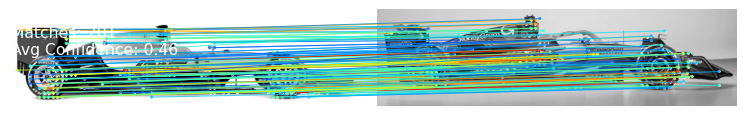

📊 Visualization shows:
  - Green lines = High confidence matches
  - Red lines = Lower confidence matches
  - Lines connect corresponding points between images


In [ ]:
# Visualize matches using LoFTR's plotting function
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Import LoFTR's visualization utility
from src.utils.plotting import make_matching_figure

# Color code matches by confidence
color = cm.jet(mconf, alpha=0.7)

# Create visualization
text = [
    'LoFTR Feature Matching',
    f'Matches: {num_matches}',
    f'Avg Confidence: {mconf.mean():.2f}'
]

fig = make_matching_figure(
    baseline_gray_resized,
    current_gray_resized,
    mkpts0,
    mkpts1,
    color,
    mkpts0,  # Show all matches
    mkpts1,
    text
)

plt.show()

print("📊 Visualization shows:")
print("  - Green lines = High confidence matches")
print("  - Red lines = Lower confidence matches")
print("  - Lines connect corresponding points between images")

In [ ]:
# Compute AFFINE transformation using LoFTR matches (BEST: no perspective distortion!)
import cv2
import numpy as np

# Get original dimensions
h_base, w_base = scale_info['baseline_orig_shape']
h_curr, w_curr = scale_info['current_orig_shape']

# Get resized dimensions
new_h_base, new_w_base = scale_info['baseline_resize_shape']
new_h_curr, new_w_curr = scale_info['current_resize_shape']

# Scale keypoints to original size
scale_x_base = w_base / new_w_base
scale_y_base = h_base / new_h_base
scale_x_curr = w_curr / new_w_curr
scale_y_curr = h_curr / new_h_curr

mkpts0_scaled = mkpts0 * np.array([scale_x_base, scale_y_base])
mkpts1_scaled = mkpts1 * np.array([scale_x_curr, scale_y_curr])

print(f"Scaling keypoints back to original size:")
print(f"  Baseline: {w_base}x{h_base}")
print(f"  Current: {w_curr}x{h_curr}")

# Filter by confidence threshold
confidence_threshold = 0.6
high_conf_mask = mconf > confidence_threshold
mkpts0_filtered = mkpts0_scaled[high_conf_mask]
mkpts1_filtered = mkpts1_scaled[high_conf_mask]

print(f"\n✓ Filtered by confidence (>{confidence_threshold}):")
print(f"  Kept: {len(mkpts0_filtered)}/{len(mkpts0_scaled)} matches")

# Lower threshold if too few matches
if len(mkpts0_filtered) < 20:
    confidence_threshold = 0.4
    high_conf_mask = mconf > confidence_threshold
    mkpts0_filtered = mkpts0_scaled[high_conf_mask]
    mkpts1_filtered = mkpts1_scaled[high_conf_mask]
    print(f"  ⚠️ Lowered to {confidence_threshold}: {len(mkpts0_filtered)} matches")

# ==================================================================
# METHOD 1: Try AFFINE transform first (translation + rotation + uniform scale)
# ==================================================================
print("\n🔧 Method 1: Computing AFFINE transformation...")
print("   (Allows: translation + rotation + uniform scale)")

M_affine, ransac_mask = cv2.estimateAffinePartial2D(
    mkpts1_filtered,  # Source (current image)
    mkpts0_filtered,  # Destination (baseline image)
    method=cv2.RANSAC,
    ransacReprojThreshold=8.0,  # Pixel tolerance (higher = more permissive)
    maxIters=3000,
    confidence=0.995,
    refineIters=10
)

if M_affine is not None:
    inliers = ransac_mask.sum()
    inlier_ratio = inliers / len(ransac_mask)

    print(f"✓ Affine transform computed!")
    print(f"  Inliers: {inliers}/{len(ransac_mask)} ({inlier_ratio*100:.1f}%)")

    # Extract transformation parameters
    scale_x = np.sqrt(M_affine[0, 0]**2 + M_affine[0, 1]**2)
    scale_y = np.sqrt(M_affine[1, 0]**2 + M_affine[1, 1]**2)
    rotation_deg = np.arctan2(M_affine[1, 0], M_affine[0, 0]) * 180 / np.pi
    tx = M_affine[0, 2]
    ty = M_affine[1, 2]

    print(f"\n📊 Transformation breakdown:")
    print(f"  Translation: ({tx:.1f}px, {ty:.1f}px)")
    print(f"  Rotation: {rotation_deg:.2f}°")
    print(f"  Scale: ({scale_x:.3f}x, {scale_y:.3f}x)")

    # Quality checks
    use_affine = True

    # Check 1: Inlier ratio
    if inlier_ratio < 0.3:
        print(f"  ⚠️ WARNING: Low inlier ratio ({inlier_ratio*100:.1f}%)")
        use_affine = False

    # Check 2: Rotation too large
    if abs(rotation_deg) > 20:
        print(f"  ⚠️ WARNING: Large rotation ({rotation_deg:.1f}°)")
        print("     Images may have very different perspectives")
        use_affine = False

    # Check 3: Extreme scaling
    if scale_x < 0.7 or scale_x > 1.5 or scale_y < 0.7 or scale_y > 1.5:
        print(f"  ⚠️ WARNING: Extreme scaling (x={scale_x:.2f}, y={scale_y:.2f})")
        use_affine = False

    if use_affine:
        # Convert to 3x3 homography format for warpPerspective
        H = np.vstack([M_affine, [0, 0, 1]])
        print(f"\n✅ AFFINE transform accepted!")
        print(f"   Will apply: {tx:.0f}px shift, {rotation_deg:.1f}° rotation, {scale_x:.2f}x scale")
    else:
        print(f"\n❌ Affine rejected - falling back to translation-only...")
        M_affine = None

else:
    print("❌ Affine computation failed!")
    M_affine = None

# ==================================================================
# METHOD 2: Fallback to TRANSLATION-ONLY if affine fails/rejected
# ==================================================================
if M_affine is None:
    print("\n🔧 Method 2: Computing TRANSLATION-ONLY transformation...")
    print("   (Allows: only horizontal/vertical shift)")

    # Calculate translation vectors for all high-confidence matches
    translations = mkpts0_filtered - mkpts1_filtered

    # Use MEDIAN (robust to outliers)
    tx_median = np.median(translations[:, 0])
    ty_median = np.median(translations[:, 1])

    print(f"\n✓ Median translation computed:")
    print(f"  Shift: ({tx_median:.1f}px, {ty_median:.1f}px)")

    # Create affine matrix for pure translation
    M_affine = np.array([
        [1.0, 0.0, tx_median],  # No rotation, no scale
        [0.0, 1.0, ty_median]
    ], dtype=np.float32)

    H = np.vstack([M_affine, [0, 0, 1]])

    print(f"\n✅ TRANSLATION-ONLY transform applied")
    print(f"   (Simple {tx_median:.0f}px, {ty_median:.0f}px shift)")

# ==================================================================
# Final transformation matrix ready
# ==================================================================
print("\n" + "="*60)
print("FINAL TRANSFORMATION MATRIX:")
print(M_affine)
print("="*60)

Scaling keypoints back to original size:
  Baseline: 1078x302
  Current: 1078x291

✓ Filtered by confidence (>0.6):
  Kept: 51/201 matches

🔧 Method 1: Computing AFFINE transformation...
   (Allows: translation + rotation + uniform scale)
✓ Affine transform computed!
  Inliers: 22/51 (43.1%)

📊 Transformation breakdown:
  Translation: (-30.1px, 34.8px)
  Rotation: -0.01°
  Scale: (1.021x, 1.021x)

✅ AFFINE transform accepted!
   Will apply: -30px shift, -0.0° rotation, 1.02x scale

FINAL TRANSFORMATION MATRIX:
[[ 1.02065041e+00  9.14907587e-05 -3.00922961e+01]
 [-9.14907587e-05  1.02065041e+00  3.48498837e+01]]


In [ ]:
# Warp the current image to align with baseline
if H is not None:
    height, width = baseline_bgr_orig.shape[:2]

    print(f"Warping 2025 current image to match 2016 baseline...")
    print(f"  Target size: {width}x{height}")

    # Warp the full-resolution original image
    aligned_current = cv2.warpPerspective(
        current_bgr_orig,
        H,
        (width, height),
        flags=cv2.INTER_LINEAR,
        borderMode=cv2.BORDER_CONSTANT,
        borderValue=(0, 0, 0)
    )

    print("✓ Warping complete!")
    print(f"  Aligned image shape: {aligned_current.shape}")

    # Save aligned image
    cv2.imwrite(os.path.join(OUTPUT_DIR, "current_aligned.jpg"), aligned_current)
    print(f"  Saved to: {OUTPUT_DIR}/current_aligned.jpg")

else:
    print("⚠️ Skipping warp - no valid homography")
    aligned_current = current_bgr_orig.copy()

Warping 2025 current image to match 2016 baseline...
  Target size: 1078x302
✓ Warping complete!
  Aligned image shape: (302, 1078, 3)
  Saved to: /content/outputs/current_aligned.jpg


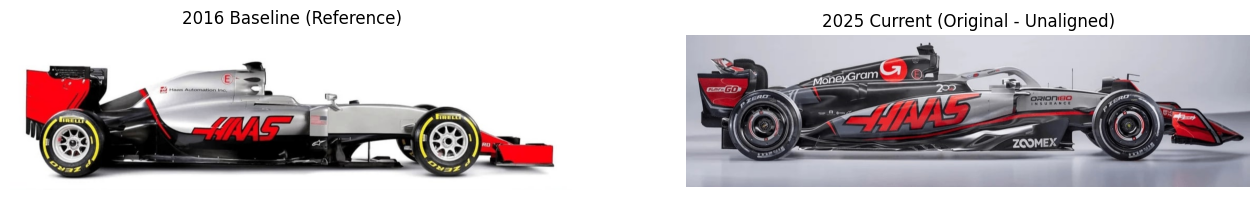

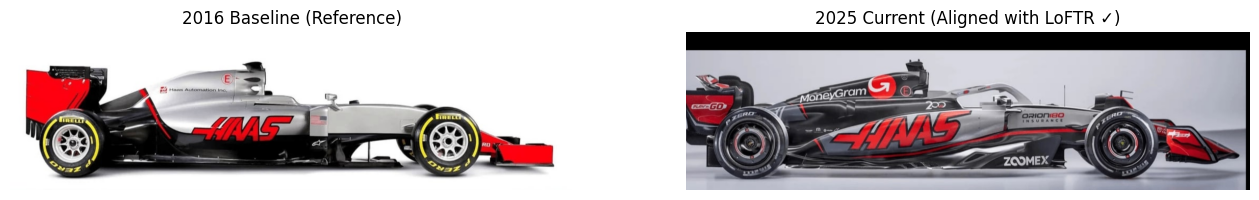

📊 Compare the two visualizations:
  - Top: Original unaligned images
  - Bottom: Baseline + LoFTR-aligned current
  - Cars should now overlap perfectly in bottom view


In [ ]:
# Visualize alignment results
import supervision as sv

if H is not None:
    # Show before/after alignment
    sv.plot_images_grid(
        images=[baseline_bgr_orig, current_bgr_orig],
        grid_size=(1, 2),
        titles=['2016 Baseline (Reference)', '2025 Current (Original - Unaligned)'],
        size=(16, 8)
    )

    sv.plot_images_grid(
        images=[baseline_bgr_orig, aligned_current],
        grid_size=(1, 2),
        titles=['2016 Baseline (Reference)', '2025 Current (Aligned with LoFTR ✓)'],
        size=(16, 8)
    )

    print("📊 Compare the two visualizations:")
    print("  - Top: Original unaligned images")
    print("  - Bottom: Baseline + LoFTR-aligned current")
    print("  - Cars should now overlap perfectly in bottom view")
else:
    print("⚠️ Cannot visualize - alignment failed")

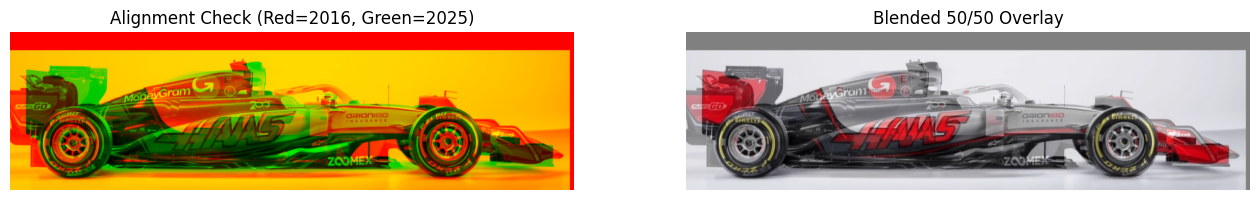

📊 Alignment Quality Indicators:
  - Left image: Red/Green overlay
    • Gray = Perfect alignment
    • Cyan/Magenta = Misalignment
  - Right image: 50/50 blend
    • Ghosting = Poor alignment
    • Clear overlap = Good alignment

✅ Pipeline Step 3 Complete: LoFTR Image Alignment
   Ready for Step 4: Change Detection


In [ ]:
# Create overlay to verify alignment quality
if H is not None:
    # Create red/green overlay (like stereo 3D)
    overlay = np.zeros_like(baseline_bgr_orig)
    overlay[:, :, 2] = cv2.cvtColor(baseline_bgr_orig, cv2.COLOR_BGR2GRAY)    # Red = baseline
    overlay[:, :, 1] = cv2.cvtColor(aligned_current, cv2.COLOR_BGR2GRAY)     # Green = current

    # Create 50/50 blend
    alpha = 0.5
    blended = cv2.addWeighted(baseline_bgr_orig, alpha, aligned_current, 1-alpha, 0)

    # Visualize
    sv.plot_images_grid(
        images=[overlay, blended],
        grid_size=(1, 2),
        titles=['Alignment Check (Red=2016, Green=2025)', 'Blended 50/50 Overlay'],
        size=(16, 8)
    )

    print("📊 Alignment Quality Indicators:")
    print("  - Left image: Red/Green overlay")
    print("    • Gray = Perfect alignment")
    print("    • Cyan/Magenta = Misalignment")
    print("  - Right image: 50/50 blend")
    print("    • Ghosting = Poor alignment")
    print("    • Clear overlap = Good alignment")

    print(f"\n✅ Pipeline Step 3 Complete: LoFTR Image Alignment")
    print(f"   Ready for Step 4: Change Detection")
else:
    print("⚠️ Cannot create overlay - alignment failed")

In [ ]:
# ============================================================================
# STEP 4: PHOTOMETRIC NORMALIZATION
# ============================================================================
# Goal: Match lighting/colors between baseline and aligned current images
# Techniques: CLAHE (contrast enhancement) + Histogram Matching

import cv2
import numpy as np
from skimage import exposure

print("="*70)
print("🎨 STEP 4: PHOTOMETRIC NORMALIZATION")
print("="*70)

# Ensure we have aligned images from previous step
if 'aligned_current' not in locals() or 'baseline_bgr_orig' not in locals():
    print("❌ ERROR: Please run alignment step (Cell 38) first!")
else:
    # -----------------------------------------------------------------------
    # Step 4.1: Apply CLAHE (Contrast Limited Adaptive Histogram Equalization)
    # -----------------------------------------------------------------------
    print("\n📊 Step 4.1: Applying CLAHE for contrast enhancement...")

    # Create CLAHE object (clipLimit controls contrast enhancement)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))

    # Apply CLAHE to each BGR channel separately
    def apply_clahe_bgr(image):
        """Apply CLAHE to each channel of a BGR image"""
        b, g, r = cv2.split(image)
        b_clahe = clahe.apply(b)
        g_clahe = clahe.apply(g)
        r_clahe = clahe.apply(r)
        return cv2.merge([b_clahe, g_clahe, r_clahe])

    # Apply to baseline
    baseline_clahe = apply_clahe_bgr(baseline_bgr_orig)
    print("  ✓ CLAHE applied to baseline image")

    # Apply to aligned current
    current_clahe = apply_clahe_bgr(aligned_current)
    print("  ✓ CLAHE applied to current image")

    # -----------------------------------------------------------------------
    # Step 4.2: Histogram Matching (match current to baseline reference)
    # -----------------------------------------------------------------------
    print("\n📊 Step 4.2: Applying histogram matching...")

    # Convert to RGB for scikit-image (it expects RGB)
    baseline_rgb = cv2.cvtColor(baseline_clahe, cv2.COLOR_BGR2RGB)
    current_rgb = cv2.cvtColor(current_clahe, cv2.COLOR_BGR2RGB)

    # Match histogram of current to baseline (channel-by-channel)
    current_matched = exposure.match_histograms(
        current_rgb,
        baseline_rgb,
        channel_axis=2  # Process each RGB channel
    )

    # Convert back to BGR
    current_normalized = cv2.cvtColor(current_matched.astype(np.uint8), cv2.COLOR_RGB2BGR)
    baseline_normalized = baseline_clahe  # Baseline already has CLAHE

    print("  ✓ Histogram matching complete")

    # -----------------------------------------------------------------------
    # Step 4.3: Quality Metrics
    # -----------------------------------------------------------------------
    print("\n📊 Step 4.3: Computing quality metrics...")

    def compute_brightness_stats(image, name):
        """Compute mean brightness for each channel"""
        b, g, r = cv2.split(image)
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        print(f"  {name}:")
        print(f"    Mean brightness: {gray.mean():.1f}")
        print(f"    Std deviation: {gray.std():.1f}")
        print(f"    RGB means: B={b.mean():.1f}, G={g.mean():.1f}, R={r.mean():.1f}")

    print("\n  Before normalization:")
    compute_brightness_stats(baseline_bgr_orig, "Baseline")
    compute_brightness_stats(aligned_current, "Current")

    print("\n  After normalization:")
    compute_brightness_stats(baseline_normalized, "Baseline (normalized)")
    compute_brightness_stats(current_normalized, "Current (normalized)")

    # -----------------------------------------------------------------------
    # Step 4.4: Save normalized images
    # -----------------------------------------------------------------------
    print("\n💾 Step 4.4: Saving normalized images...")

    cv2.imwrite(os.path.join(OUTPUT_DIR, "baseline_normalized.jpg"), baseline_normalized)
    cv2.imwrite(os.path.join(OUTPUT_DIR, "current_normalized.jpg"), current_normalized)

    print(f"  ✓ Saved: {OUTPUT_DIR}/baseline_normalized.jpg")
    print(f"  ✓ Saved: {OUTPUT_DIR}/current_normalized.jpg")

    print("\n" + "="*70)
    print("✅ PHOTOMETRIC NORMALIZATION COMPLETE!")
    print("="*70)
    print("\nNormalized images ready for change detection (Step 5)")

🎨 STEP 4: PHOTOMETRIC NORMALIZATION

📊 Step 4.1: Applying CLAHE for contrast enhancement...
  ✓ CLAHE applied to baseline image
  ✓ CLAHE applied to current image

📊 Step 4.2: Applying histogram matching...
  ✓ Histogram matching complete

📊 Step 4.3: Computing quality metrics...

  Before normalization:
  Baseline:
    Mean brightness: 184.3
    Std deviation: 93.3
    RGB means: B=180.0, G=180.4, R=193.6
  Current:
    Mean brightness: 119.4
    Std deviation: 77.6
    RGB means: B=123.6, G=115.8, R=124.8

  After normalization:
  Baseline (normalized):
    Mean brightness: 186.7
    Std deviation: 88.1
    RGB means: B=184.3, G=183.7, R=193.6
  Current (normalized):
    Mean brightness: 188.2
    Std deviation: 84.7
    RGB means: B=185.3, G=184.8, R=195.8

💾 Step 4.4: Saving normalized images...
  ✓ Saved: /content/outputs/baseline_normalized.jpg
  ✓ Saved: /content/outputs/current_normalized.jpg

✅ PHOTOMETRIC NORMALIZATION COMPLETE!

Normalized images ready for change detection (

📊 Visualizing normalization results...


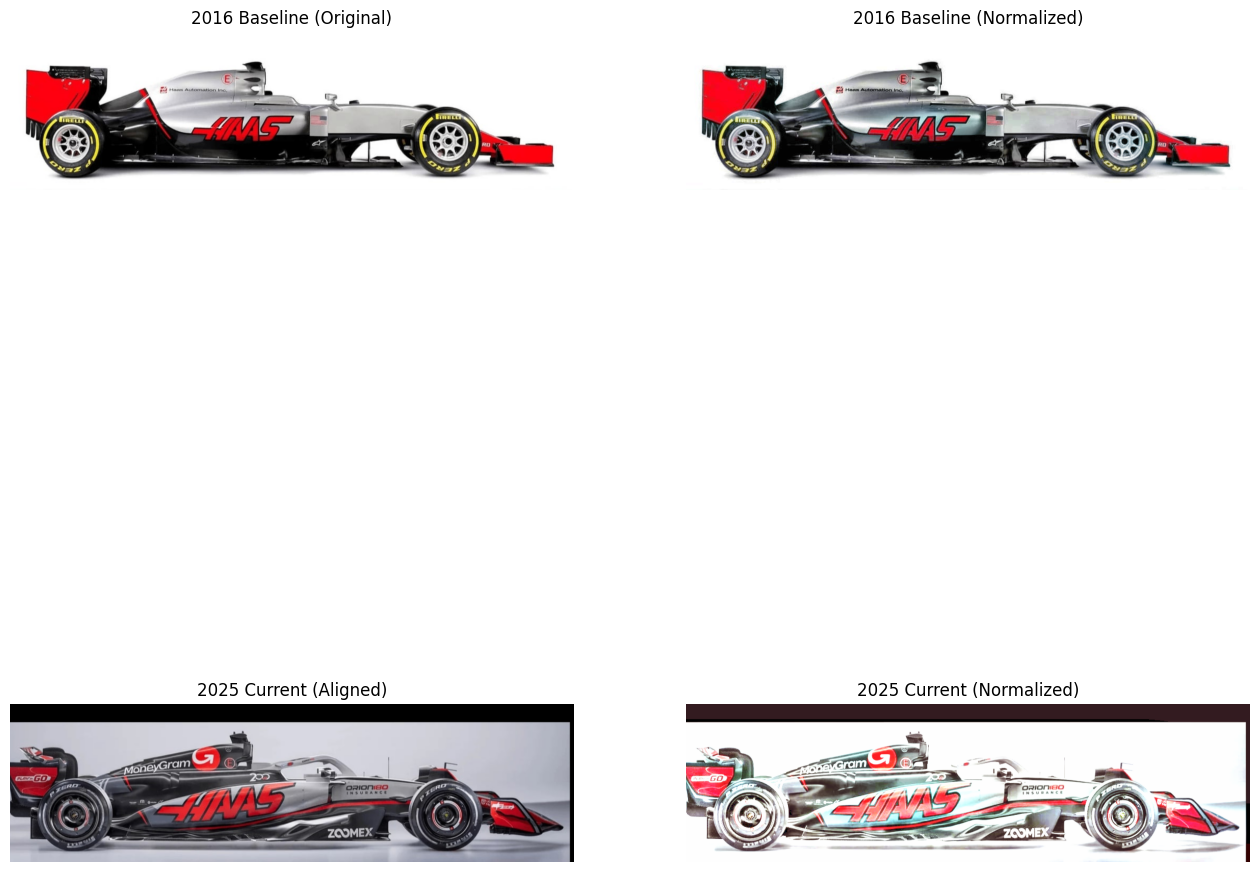


📊 Histogram comparison:


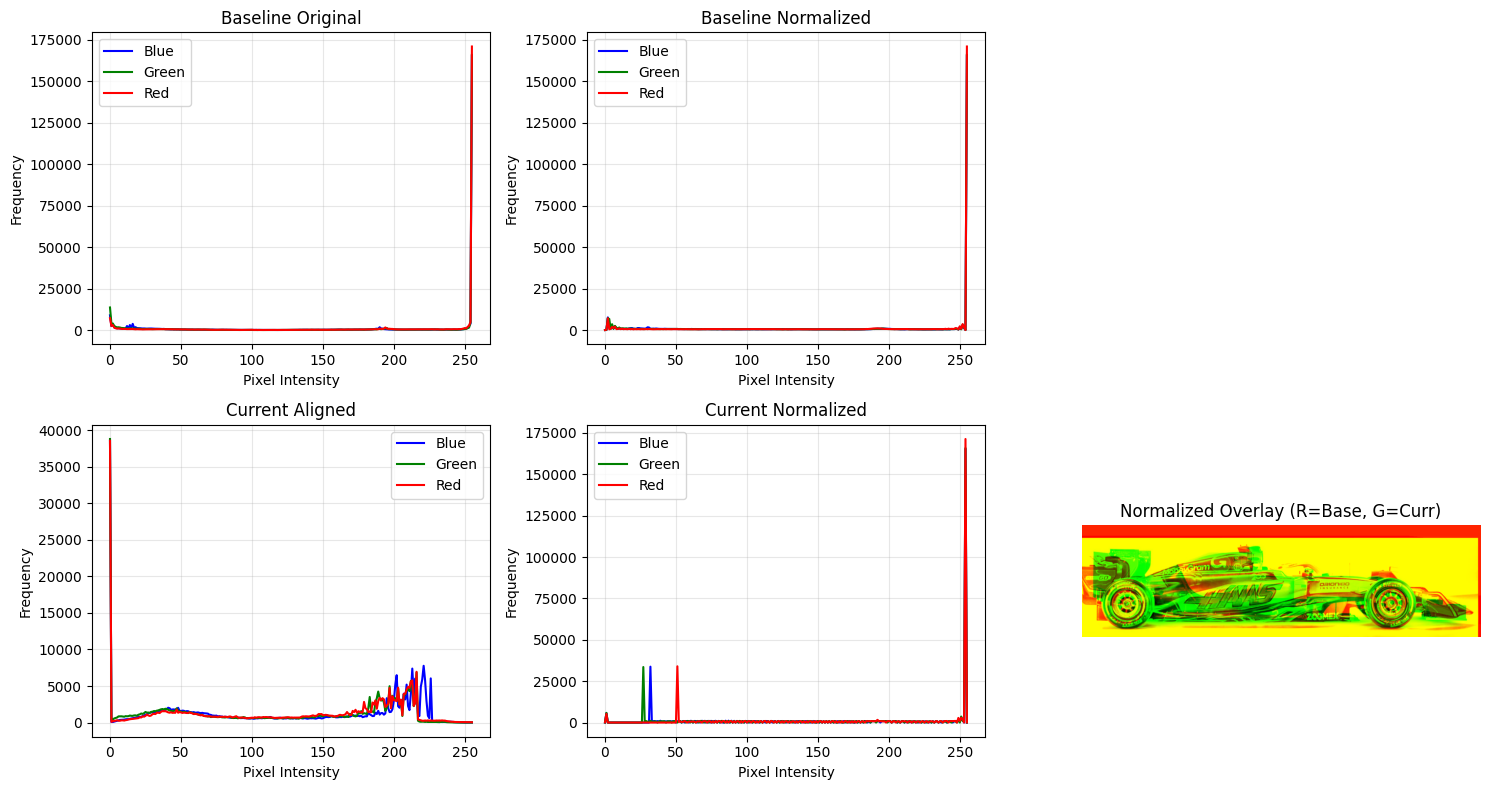


✅ Visualization complete!

📊 What to look for:
  ✓ Histograms should be more similar after normalization
  ✓ Overlay should show more gray (aligned) regions
  ✓ Colors should appear more consistent between images


In [ ]:
# ============================================================================
# STEP 4: VISUALIZATION - Before/After Normalization Comparison
# ============================================================================

import supervision as sv
import matplotlib.pyplot as plt

print("📊 Visualizing normalization results...")

if 'baseline_normalized' in locals() and 'current_normalized' in locals():

    # -----------------------------------------------------------------------
    # Visualization 1: Side-by-side comparison (4 images)
    # -----------------------------------------------------------------------
    sv.plot_images_grid(
        images=[
            baseline_bgr_orig,      # Original baseline
            baseline_normalized,    # Normalized baseline
            aligned_current,        # Aligned current (before normalization)
            current_normalized      # Normalized current
        ],
        grid_size=(2, 2),
        titles=[
            '2016 Baseline (Original)',
            '2016 Baseline (Normalized)',
            '2025 Current (Aligned)',
            '2025 Current (Normalized)'
        ],
        size=(16, 16)
    )

    # -----------------------------------------------------------------------
    # Visualization 2: Histograms comparison
    # -----------------------------------------------------------------------
    print("\n📊 Histogram comparison:")

    fig, axes = plt.subplots(2, 3, figsize=(15, 8))

    def plot_histogram(ax, image, title, color_labels):
        """Plot RGB histograms for an image"""
        colors = ('b', 'g', 'r')
        for i, (col, label) in enumerate(zip(colors, color_labels)):
            hist = cv2.calcHist([image], [i], None, [256], [0, 256])
            ax.plot(hist, color=col, label=label)
        ax.set_title(title)
        ax.set_xlabel('Pixel Intensity')
        ax.set_ylabel('Frequency')
        ax.legend()
        ax.grid(alpha=0.3)

    # Row 1: Baseline histograms
    plot_histogram(axes[0, 0], baseline_bgr_orig, 'Baseline Original', ['Blue', 'Green', 'Red'])
    plot_histogram(axes[0, 1], baseline_normalized, 'Baseline Normalized', ['Blue', 'Green', 'Red'])
    axes[0, 2].axis('off')  # Empty cell

    # Row 2: Current histograms
    plot_histogram(axes[1, 0], aligned_current, 'Current Aligned', ['Blue', 'Green', 'Red'])
    plot_histogram(axes[1, 1], current_normalized, 'Current Normalized', ['Blue', 'Green', 'Red'])

    # Overlay comparison (normalized images)
    overlay_norm = np.zeros_like(baseline_normalized)
    overlay_norm[:, :, 2] = cv2.cvtColor(baseline_normalized, cv2.COLOR_BGR2GRAY)  # Red
    overlay_norm[:, :, 1] = cv2.cvtColor(current_normalized, cv2.COLOR_BGR2GRAY)   # Green
    axes[1, 2].imshow(cv2.cvtColor(overlay_norm, cv2.COLOR_BGR2RGB))
    axes[1, 2].set_title('Normalized Overlay (R=Base, G=Curr)')
    axes[1, 2].axis('off')

    plt.tight_layout()
    plt.show()

    print("\n✅ Visualization complete!")
    print("\n📊 What to look for:")
    print("  ✓ Histograms should be more similar after normalization")
    print("  ✓ Overlay should show more gray (aligned) regions")
    print("  ✓ Colors should appear more consistent between images")

else:
    print("❌ ERROR: Run normalization step (Cell 44) first!")

In [ ]:
# ============================================================================
# PIPELINE STATUS: Steps 1-4 Complete
# ============================================================================

import os

print("="*70)
print("🏁 F1 VISUAL CHANGE DETECTION PIPELINE - STATUS")
print("="*70)

# Check what's been completed
steps_status = {
    "Step 1: Image Input": os.path.isfile(BASELINE_PATH) and os.path.isfile(CURRENT_PATH),
    "Step 2: SAM Segmentation": 'baseline_sam_result' in locals(),
    "Step 3: LoFTR Alignment": 'aligned_current' in locals(),
    "Step 4: Photometric Normalization": 'baseline_normalized' in locals() and 'current_normalized' in locals()
}

for step, status in steps_status.items():
    symbol = "✅" if status else "❌"
    print(f"{symbol} {step}")

print("\n" + "="*70)

if all(steps_status.values()):
    print("🎉 ALL PREPROCESSING STEPS COMPLETE!")
    print("\n📁 Output Files:")
    output_files = [
        "baseline_original.jpg",
        "current_original.jpg",
        "current_aligned.jpg",
        "baseline_normalized.jpg",
        "current_normalized.jpg"
    ]

    for filename in output_files:
        filepath = os.path.join(OUTPUT_DIR, filename)
        if os.path.isfile(filepath):
            size_kb = os.path.getsize(filepath) / 1024
            print(f"  ✓ {filename} ({size_kb:.1f} KB)")

    print("\n🚀 READY FOR NEXT STEPS:")
    print("  → Step 5: Change Detection (Siamese CNN/Transformer)")
    print("  → Step 6: Few-Shot Part Classification")
    print("  → Step 7: Uncertainty Estimation")
    print("  → Step 8: XAI Overlays (GradCAM)")
    print("  → Step 9: Report Generation")

    print("\n📊 Variables ready for next step:")
    print(f"  • baseline_normalized: {baseline_normalized.shape}")
    print(f"  • current_normalized: {current_normalized.shape}")
    print(f"  • OUTPUT_DIR: {OUTPUT_DIR}")

else:
    print("\n⚠️ INCOMPLETE PIPELINE!")
    print("Please complete all steps before proceeding.")

print("="*70)

🏁 F1 VISUAL CHANGE DETECTION PIPELINE - STATUS
✅ Step 1: Image Input
✅ Step 2: SAM Segmentation
✅ Step 3: LoFTR Alignment
✅ Step 4: Photometric Normalization

🎉 ALL PREPROCESSING STEPS COMPLETE!

📁 Output Files:
  ✓ baseline_original.jpg (59.5 KB)
  ✓ current_original.jpg (81.0 KB)
  ✓ current_aligned.jpg (87.9 KB)
  ✓ baseline_normalized.jpg (68.4 KB)
  ✓ current_normalized.jpg (109.3 KB)

🚀 READY FOR NEXT STEPS:
  → Step 5: Change Detection (Siamese CNN/Transformer)
  → Step 6: Few-Shot Part Classification
  → Step 7: Uncertainty Estimation
  → Step 8: XAI Overlays (GradCAM)
  → Step 9: Report Generation

📊 Variables ready for next step:
  • baseline_normalized: (302, 1078, 3)
  • current_normalized: (302, 1078, 3)
  • OUTPUT_DIR: /content/outputs


In [ ]:
# ============================================================================
# STEP 5: CHANGE DETECTION - Install Dependencies
# ============================================================================

import os
import sys

print("="*70)
print("🔍 STEP 5: CHANGE DETECTION (SEGMENT ANY CHANGE)")
print("="*70)

print("\n📦 Installing pytorch-change-models (torchange)...")

# Clone the pytorch-change-models repository
!git clone https://github.com/Z-Zheng/pytorch-change-models.git {HOME}/pytorch-change-models

# Add to Python path
TORCHANGE_PATH = os.path.join(HOME, "pytorch-change-models")
if TORCHANGE_PATH not in sys.path:
    sys.path.insert(0, TORCHANGE_PATH)

print(f"✓ Repository cloned to: {TORCHANGE_PATH}")

# Install required dependencies
print("\n📦 Installing dependencies...")
!pip install -q scikit-image torch torchvision

print("✓ All dependencies installed")
print(f"✓ torchange path added to sys.path")

🔍 STEP 5: CHANGE DETECTION (SEGMENT ANY CHANGE)

📦 Installing pytorch-change-models (torchange)...
Cloning into '/content/pytorch-change-models'...
remote: Enumerating objects: 559, done.
remote: Counting objects: 100% (155/155), done.
remote: Compressing objects: 100% (38/38), done.
remote: Total 559 (delta 124), reused 128 (delta 116), pack-reused 404 (from 1)
Receiving objects: 100% (559/559), 4.28 MiB | 16.37 MiB/s, done.
Resolving deltas: 100% (350/350), done.
✓ Repository cloned to: /content/pytorch-change-models

📦 Installing dependencies...
✓ All dependencies installed
✓ torchange path added to sys.path


In [ ]:
# ============================================================================
# STEP 5: Verify SAM Checkpoint for AnyChange
# ============================================================================

import os

print("\n🔍 Checking SAM checkpoint...")

# AnyChange requires the same SAM checkpoint we already downloaded
SAM_CHECKPOINT = os.path.join(HOME, "weights", "sam_vit_h_4b8939.pth")

if os.path.isfile(SAM_CHECKPOINT):
    print(f"✓ SAM checkpoint found: {SAM_CHECKPOINT}")
    print(f"  File size: {os.path.getsize(SAM_CHECKPOINT) / (1024**3):.2f} GB")
else:
    print("❌ SAM checkpoint not found!")
    print("⚠️ Please ensure Cell 9 (Download SAM weights) was executed successfully")
    raise FileNotFoundError(f"SAM checkpoint not found at: {SAM_CHECKPOINT}")

print("\n✅ SAM checkpoint ready for AnyChange")


🔍 Checking SAM checkpoint...
✓ SAM checkpoint found: /content/weights/sam_vit_h_4b8939.pth
  File size: 2.39 GB

✅ SAM checkpoint ready for AnyChange


In [ ]:
pip install ever-beta

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.5/122.5 kB 7.8 MB/s eta 0:00:00


In [ ]:
# ============================================================================
# STEP 5: Initialize AnyChange Model
# ============================================================================

from torchange.models.segment_any_change import AnyChange

print("\n🤖 Initializing AnyChange model...")

# Initialize AnyChange with ViT-H (same as our SAM model)
anychange_model = AnyChange(
    model_type='vit_h',  # Must match our downloaded SAM checkpoint
    sam_checkpoint=SAM_CHECKPOINT
)

print("✓ AnyChange model initialized")
print(f"  Model type: vit_h")
print(f"  Device: {anychange_model.device}")

# ============================================================================
# Configure SAM Mask Generator
# ============================================================================
print("\n⚙️ Configuring SAM mask generator...")

anychange_model.make_mask_generator(
    points_per_side=32,              # Grid density (32x32 = 1024 points)
    stability_score_thresh=0.95,     # Only keep stable masks
    pred_iou_thresh=0.88,            # High quality threshold
    box_nms_thresh=0.7               # Remove overlapping masks
)

print("✓ Mask generator configured")
print("  Points per side: 32")
print("  Stability threshold: 0.95")
print("  IoU threshold: 0.88")

# ============================================================================
# Set AnyChange Hyperparameters
# ============================================================================
print("\n⚙️ Setting AnyChange hyperparameters...")

anychange_model.set_hyperparameters(
    change_confidence_threshold=145,  # Lower = more sensitive (default: 145)
    use_normalized_feature=True,      # Better for lighting variations
    bitemporal_match=True,            # Match masks in both directions
    match_hist=False,                 # We already did histogram matching in Step 4!
    area_thresh=0.8,                  # Filter masks > 80% of image area
)

print("✓ Hyperparameters set")
print("  Change confidence threshold: 145")
print("  Normalized features: True")
print("  Bitemporal matching: True")
print("  Histogram matching: False (already done in Step 4)")

print("\n✅ AnyChange model ready for inference")


🤖 Initializing AnyChange model...
✓ AnyChange model initialized
  Model type: vit_h
  Device: cuda

⚙️ Configuring SAM mask generator...
✓ Mask generator configured
  Points per side: 32
  Stability threshold: 0.95
  IoU threshold: 0.88

⚙️ Setting AnyChange hyperparameters...
✓ Hyperparameters set
  Change confidence threshold: 145
  Normalized features: True
  Bitemporal matching: True
  Histogram matching: False (already done in Step 4)

✅ AnyChange model ready for inference


In [ ]:
# ============================================================================
# STEP 5: Run Change Detection on Normalized Images
# ============================================================================

import numpy as np
import cv2

print("\n🔍 Running AnyChange on normalized F1 car images...")

# Ensure we have normalized images from Step 4
if 'baseline_normalized' not in locals() or 'current_normalized' not in locals():
    print("❌ ERROR: Normalized images not found!")
    print("   Please run Step 4 (Photometric Normalization) first")
    raise ValueError("Missing normalized images")

# Convert BGR to RGB (AnyChange expects RGB)
baseline_rgb = cv2.cvtColor(baseline_normalized, cv2.COLOR_BGR2RGB)
current_rgb = cv2.cvtColor(current_normalized, cv2.COLOR_BGR2RGB)

print(f"✓ Images prepared for AnyChange:")
print(f"  Baseline: {baseline_rgb.shape} (RGB)")
print(f"  Current:  {current_rgb.shape} (RGB)")

# ============================================================================
# Run AnyChange Forward Pass
# ============================================================================
print("\n⏳ Running change detection (this may take 10-30 seconds)...")

import time
start_time = time.time()

# Forward pass: Returns (change_masks, t1_masks, t2_masks)
change_masks, baseline_masks, current_masks = anychange_model.forward(
    baseline_rgb,  # Time 1 (2016 baseline)
    current_rgb    # Time 2 (2025 current)
)

elapsed = time.time() - start_time

print(f"\n✅ Change detection complete! (took {elapsed:.1f} seconds)")

# ============================================================================
# Analyze Results
# ============================================================================
print("\n📊 Detection Results:")
print(f"  Total change masks detected: {len(change_masks['rles'])}")

if len(change_masks['rles']) > 0:
    # Get change confidence scores
    confidences = change_masks['change_confidence'].cpu().numpy()

    print(f"  Average confidence: {confidences.mean():.3f}")
    print(f"  Min confidence: {confidences.min():.3f}")
    print(f"  Max confidence: {confidences.max():.3f}")

    # Get change areas
    if 'areas' in change_masks._stats:
        areas = change_masks['areas']
        if isinstance(areas, torch.Tensor):
            areas = areas.cpu().numpy()
        print(f"\n  Change areas (pixels):")
        print(f"    Total pixels changed: {areas.sum():.0f}")
        print(f"    Average change size: {areas.mean():.0f} px")
        print(f"    Largest change: {areas.max():.0f} px")
        print(f"    Smallest change: {areas.min():.0f} px")

    # Quality assessment
    high_conf_count = (confidences > 0.5).sum()
    print(f"\n  Quality Assessment:")
    print(f"    High confidence changes (>0.5): {high_conf_count}/{len(confidences)}")

    if high_conf_count > 10:
        print("    ✅ Excellent - Many significant changes detected!")
    elif high_conf_count > 5:
        print("    ✓ Good - Several changes detected")
    elif high_conf_count > 0:
        print("    ⚠️ Few changes - May include noise")
    else:
        print("    ❌ No high-confidence changes detected")

else:
    print("  ⚠️ No changes detected between images!")
    print("     Possible reasons:")
    print("     - Images are too similar")
    print("     - Change confidence threshold too high")
    print("     - Alignment issues")

print("\n" + "="*70)


🔍 Running AnyChange on normalized F1 car images...
✓ Images prepared for AnyChange:
  Baseline: (302, 1078, 3) (RGB)
  Current:  (302, 1078, 3) (RGB)

⏳ Running change detection (this may take 10-30 seconds)...

✅ Change detection complete! (took 14.7 seconds)

📊 Detection Results:
  Total change masks detected: 0
  ⚠️ No changes detected between images!
     Possible reasons:
     - Images are too similar
     - Change confidence threshold too high
     - Alignment issues



📊 Visualizing change detection results...
⚠️ No changes to visualize


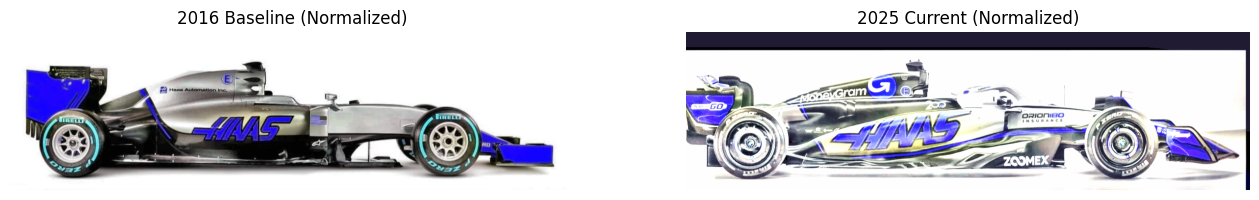


No changes detected - images appear identical after normalization


In [ ]:
# ============================================================================
# STEP 5: Visualize Change Detection Results
# ============================================================================

from torchange.models.segment_any_change import show_change_masks
import matplotlib.pyplot as plt

print("📊 Visualizing change detection results...")

if len(change_masks['rles']) > 0:
    # Use the official visualization function
    fig, axes = show_change_masks(baseline_rgb, current_rgb, change_masks)

    # Add title
    fig.suptitle(
        f'AnyChange Detection Results: {len(change_masks["rles"])} changes detected',
        fontsize=14,
        fontweight='bold',
        y=0.98
    )

    # Adjust layout
    plt.tight_layout()
    plt.show()

    print("\n📊 Visualization Explanation:")
    print("  Left panel:   2016 Baseline with change masks overlaid")
    print("  Middle panel: 2025 Current with change masks overlaid")
    print("  Right panel:  Change masks on white background")
    print("\n  Each colored region = detected change")
    print("  Cyan boundaries = mask edges")

else:
    print("⚠️ No changes to visualize")

    # Show images side-by-side for comparison
    import supervision as sv
    sv.plot_images_grid(
        images=[baseline_rgb, current_rgb],
        grid_size=(1, 2),
        titles=['2016 Baseline (Normalized)', '2025 Current (Normalized)'],
        size=(16, 8)
    )
    print("\nNo changes detected - images appear identical after normalization")